_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-05-21, 9am

Student names: Guillem Boada-Gardenyes, Peter El-Jiz, Ulzii-Utas Narantsatsralt

In [2]:
import sys
def sprintf(format, *values):
    s = format % values 
    return s

def printf(format, *values):
    sys.stdout.write(format % values)

# Exercise sheet 4

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `np.decimate`.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat

sns.set_style('whitegrid')
%matplotlib inline


# https://github.com/j-friedrich/OASIS/blob/master/examples/Demo.ipynb
from oasis.functions import gen_data as oasis_gen_data, gen_sinusoidal_data as oasis_gen_sinusoidal_data, estimate_parameters as oasis_estimate_parameters, deconvolve as oasis_deconvolve
from oasis.plotting import simpleaxis as oasis_simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2 

# http://lucastheis.github.io/c2s/
import c2s

# https://github.com/liubenyuan/py-oopsi/blob/master/demo.py
import oopsi

## Load data

In [4]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv('../data/nda_ex_4_ogb_calcium.csv', header=0)  
ogb_spikes = pd.read_csv('../data/nda_ex_4_ogb_spikes.csv', header=0)  

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv('../data/nda_ex_4_gcamp2_calcium.csv', header=0)  
gcamp_spikes = pd.read_csv('../data/nda_ex_4_gcamp2_spikes.csv', header=0)  

sample_f = 100 
resample_f = 25

In [5]:
printf("OGB Calcium shape: %s\n", np.shape(ogb_calcium))
printf("OGB Spikes Shape: %s\n", np.shape(ogb_spikes))
printf("GCAMP Calcium Shape: %s\n", np.shape(gcamp_calcium)) 
printf("GCAMP Spikes Shape: %s\n", np.shape(gcamp_spikes))

OGB Calcium shape: (71986, 11)
OGB Spikes Shape: (71986, 11)
GCAMP Calcium Shape: (23973, 37)
GCAMP Spikes Shape: (23973, 37)


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

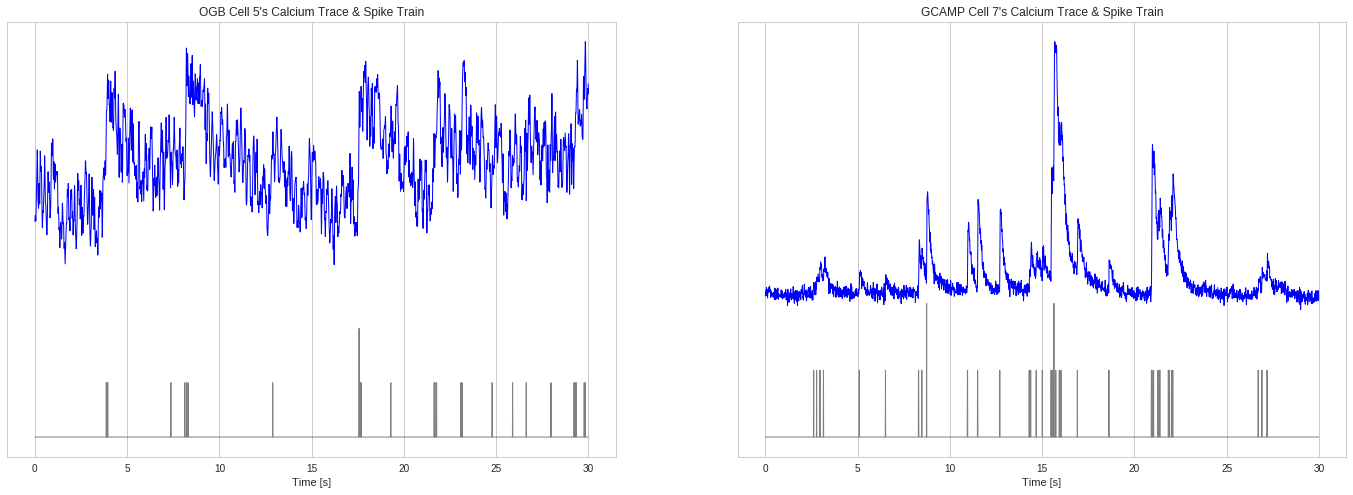

In [6]:
plt.figure(figsize=(24, 8))

dt = 1/sample_f
segment_size = 30
t = np.arange(0, segment_size, dt)


ogbPlot = plt.subplot(1, 2, 1)
ogbPlot.axes.get_yaxis().set_visible(False)

# We will be plotting the 5th cell
ogb_cell_calcium, ogb_cell_spikes = ogb_calcium['4'], ogb_spikes['4']
# Rescale the spikes and shift them 
ogb_cell_spikes = ogb_cell_spikes * 0.5 - 2

# We will be plotting the 7th cell
gcamp_cell_calcium, gcamp_cell_spikes = gcamp_calcium['6'], gcamp_spikes['6']
# Rescale the spikes and shift them 
gcamp_cell_calcium = gcamp_cell_calcium
gcamp_cell_spikes = gcamp_cell_spikes * 3 - 6


plt.title("OGB Cell 5's Calcium Trace & Spike Train")
plt.xlabel("Time [s]")
plt.plot(t, ogb_cell_calcium[0:(int)(segment_size/dt)], 'blue', linewidth=1)
plt.plot(t, ogb_cell_spikes[0:(int)(segment_size/dt)], 'gray', linewidth=1)

gcampPlot = plt.subplot(1, 2, 2)
gcampPlot.axes.get_yaxis().set_visible(False)  
plt.title("GCAMP Cell 7's Calcium Trace & Spike Train")
plt.xlabel("Time [s]")
plt.plot(t, gcamp_cell_calcium[0:(int)(segment_size/dt)], 'blue', linewidth=1)
plt.plot(t, gcamp_cell_spikes[0:(int)(segment_size/dt)], 'gray', linewidth=1)

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

*Grading: 3 pts*


## Exponential Kernel

A 2D exponential kernel is a kernel of the form: $ k_{\textrm{Exp}}(x, y) = \sigma^2 e^{\left(-\frac{\mid x - y\mid}{\theta}\right)} $

A 1D exponential kernel is a kernel of the form: $ k_{\textrm{Exp}}(x) = \sigma^2 e^{\left(-\frac{\mid x \mid}{\theta}\right)} $ 

Some sources even omit the variance $\sigma^2$. I'm assuming this has to do with the variance being "unit variance"?

<br>

We're told to "assume an exponential kernel with a decay constant depending on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$)". 

Our kernel is in the time domain, and since our $t$'s are all positive, we will omit the $\mid$

$ k_{\textrm{OGB}}(t) = e^{\left(-\frac{t}{\tau_{OGB}}\right)} \ \ \text{and} \ \ k_{\textrm{GCaMP}}(t) = e^{\left(-\frac{t}{\tau_{GCaMP}}\right)} $

<br>

Sources: [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) ; [Classes of Kernels for Machine Learning: A Statistics Perspective](http://www.jmlr.org/papers/volume2/genton01a/genton01a.pdf) ; [Kernel Functions for Machine Learning Applications](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/#exponential) ; [Kernel Design](http://gpss.cc/gpuqss16/slides/durrande_school.pdf) ; [1D Gaussian Kernel](http://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf)


In [7]:
def deconv_ca(ca, sp, tau):
# Compute the deconvolved calcium signal 
#   sp_hat = deconv_ca(ca, sp, tau) computes the deconvolved calcium signal
#   using the indicator dependent exponential calcium kernel.
#
#   ca:    1 by T
#   sp:    1 by T
#   tau:   1 by 1
#
#   sp_hat: 1 by T

   # fill your code here     
    dt = 1/25 
    t_kernel = np.arange(0, int(tau/dt)/4, dt)    
    kernel = np.exp(-t_kernel / tau) # kernel = 1 / kernel
    
    sp_hat, _ = signal.deconvolve(ca, kernel) 
    
    # Apply a heaviside function to the output to get rid of negative rates.
    sp_hat[sp_hat<0] = 0 # remove negative rates
    
    # Preserve input dimensions by padding the transformed signal 
    sp_hat = np.append(sp_hat, np.zeros((np.shape(sp)[0] - np.shape(sp_hat)[0])))
    
    return t_kernel, kernel, sp_hat

In [8]:
def c2s_ca(ca, sp, tau):
    data = [{'calcium': ca, 'fps': 100}]
    data = c2s.preprocess(data, fps=25)
    sp_hat = c2s.predict(data)[0]['predictions'][0]
    # Preserve input dimensions by padding the transformed signal  
    sp_hat = np.append(sp_hat, np.zeros((np.shape(sp)[0] - np.shape(sp_hat)[0])))
    return sp_hat

In [9]:
def inferSpikesFromCa(ca, sp, tau, padLength, algorithm="deconvolution"):
   # fill your code here 
    dt = 1/25 
    
    if algorithm == "deconvolution":
        return deconv_ca(ca, sp, tau)
    elif algorithm == "c2s": 
        data = [{'calcium': ca, 'fps': 100}]
        data = c2s.preprocess(data, fps=25)
        sp_hat = c2s.predict(data)[0]['predictions'][0]
        # Preserve input dimensions by padding the transformed signal  
        sp_hat = np.append(sp_hat, np.zeros((padLength - np.shape(sp_hat)[0])))
        return sp_hat
    elif algorithm == "oopsi-fast": 
        return oopsi.fast(ca, dt=dt, iter_max=6)
    elif algorithm == "oopsi-wiener": 
        return oopsi.wiener(ca, dt=dt, iter_max=100)
    elif algorithm == "oopsi-binning": 
        return oopsi.discretize(ca, bins=[0.75])        
    elif algorithm == "oasis": 
        return oasis_deconvolve(ca, penalty=1)

#### Apply the function to the example OGB cell

In [10]:
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

tau = .5

t_kernel, kernel, sp_hat = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0])

Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

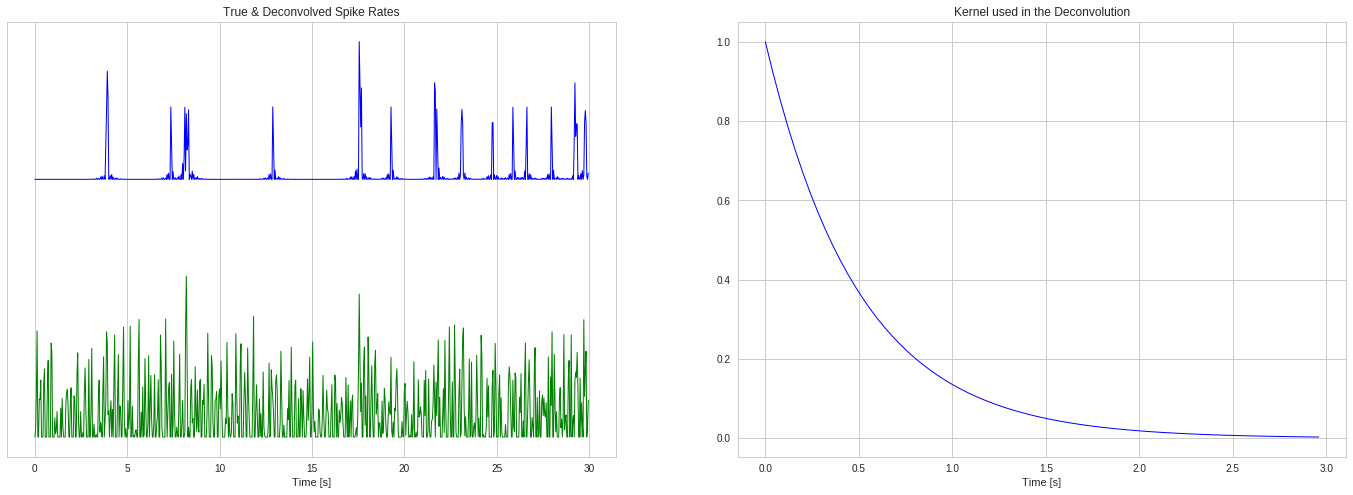

In [11]:
# fill in plot here
plt.figure(figsize=(24, 8))

dt = 1/25
segment_size = 30
t = np.arange(0, segment_size, dt)

# shiftDistance = np.max(sp_hat)

spikesPlot = plt.subplot(1, 2, 1)
spikesPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Deconvolved Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[0:(int)(segment_size/dt)]+0.7, 'blue', linewidth=1)
plt.plot(t, sp_hat[0:(int)(segment_size/dt)]*0.7, 'green', linewidth=1)

kernelPlot = plt.subplot(1, 2, 2)
plt.title("Kernel used in the Deconvolution")
plt.xlabel("Time [s]")
plt.plot(t_kernel, kernel, 'blue', linewidth=1)

#### Apply the function to the example GCamP cell

In [12]:
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts


tau = .1

t_kernel, kernel, sp_hat = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0])

Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

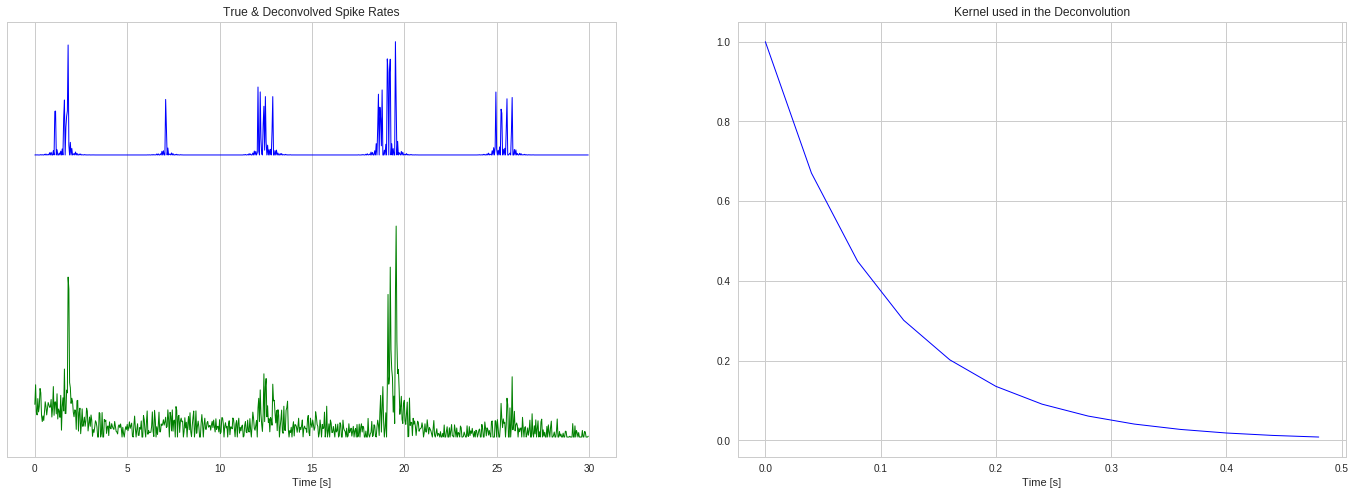

In [13]:
# fill in plot here 
plt.figure(figsize=(24, 8))

dt = 1/25
segment_size = 30
t = np.arange(0, segment_size, dt)

# shiftDistance = np.max(sp_hat)

spikesPlot = plt.subplot(1, 2, 1)
spikesPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Deconvolved Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+1, 'blue', linewidth=1)
plt.plot(t, sp_hat[5000:5000+(int)(segment_size/dt)]*0.2, 'green', linewidth=1)

kernelPlot = plt.subplot(1, 2, 2)
plt.title("Kernel used in the Deconvolution")
plt.xlabel("Time [s]")
plt.plot(t_kernel, kernel, 'blue', linewidth=1)

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

Note: If you have troubles with installing one of them maybe try another.

*Grading: 2 pts*



#### Apply the algorithms to the example OGB cell

In [73]:
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4)
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

tau = .5

# fill in algorithm here 
sp_hat_c2s = inferSpikesFromCa(ogb_calcium.iloc[:,idx], ogb_spikes.iloc[:,idx], tau, np.shape(sp)[0], algorithm="c2s")
sp_hat_oasis = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oasis")[1]
sp_hat_oopsi_binning = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oopsi-binning")[0]
sp_hat_oopsi_fast = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oopsi-fast")[0]
sp_hat_oopsi_wiener = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oopsi-wiener")[0]

/opt/conda/lib/python3.6/site-packages/c2s/c2s.py:509: UserWarning: The default model expects calcium traces sampled at 100 Hz.
  warn('The default model expects calcium traces sampled at 100 Hz.')
/opt/conda/lib/python3.6/site-packages/oasis/functions.py:815: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[1:])[0]


Predicting cell 0...


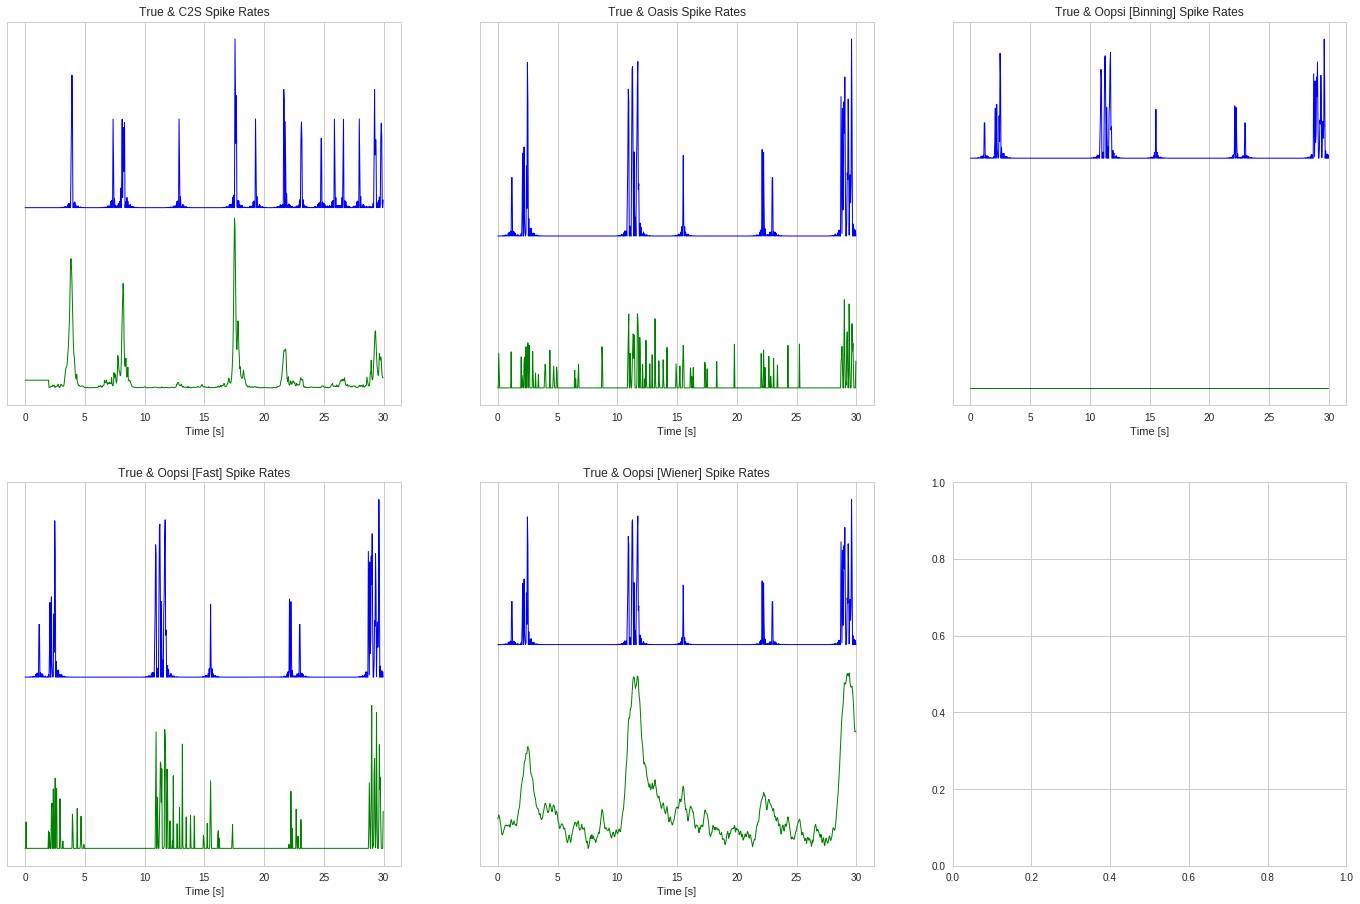

In [74]:
# fill in plot here
plt.figure(figsize=(24, 24))

dt = 1/25
segment_size = 30
t = np.arange(0, segment_size, dt)

c2sPlot = plt.subplot(3, 3, 1)
c2sPlot.axes.get_yaxis().set_visible(False)
plt.title("True & C2S Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[0:(int)(segment_size/dt)]+0.4, 'blue', linewidth=1)
plt.plot(t, sp_hat_c2s[0:(int)(segment_size/dt)], 'green', linewidth=1)


oasisPlot = plt.subplot(3, 3, 2)
oasisPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oasis Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+0.4, 'blue', linewidth=1)
plt.plot(t, sp_hat_oasis[5000:5000+(int)(segment_size/dt)]*0.4, 'green', linewidth=1)

oopsiBinningPlot = plt.subplot(3, 3, 3)
oopsiBinningPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oopsi [Binning] Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+1, 'blue', linewidth=1)
plt.plot(t, sp_hat_oopsi_binning[5000:5000+(int)(segment_size/dt)]*0.8, 'green', linewidth=1)

oopsiFastPlot = plt.subplot(3, 3, 4)
oopsiFastPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oopsi [Fast] Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+0.5, 'blue', linewidth=1)
plt.plot(t, sp_hat_oopsi_fast[5000:5000+(int)(segment_size/dt)]*0.6, 'green', linewidth=1)

oopsiWienerPlot = plt.subplot(3, 3, 5)
oopsiWienerPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oopsi [Wiener] Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+0.7, 'blue', linewidth=1)
plt.plot(t, sp_hat_oopsi_wiener[5000:5000+(int)(segment_size/dt)]*0.8, 'green', linewidth=1)

lastPlot = plt.subplot(3, 3, 6)
# plt.text(0.5, 0.5, "😂", fontproperties=prop)

#### Apply the algorithms to the example GCamP cell

In [49]:
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
sp[sp<0] = 0 # remove decimation artefacts

tau = .1

# fill in algorithm here 
sp_hat_c2s = inferSpikesFromCa(gcamp_calcium.iloc[:,idx], gcamp_spikes.iloc[:,idx], tau, np.shape(sp)[0], algorithm="c2s")
sp_hat_oasis = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oasis")[1]
sp_hat_oopsi_binning = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oopsi-binning")[0]
sp_hat_oopsi_fast = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oopsi-fast")[0]
sp_hat_oopsi_wiener = inferSpikesFromCa(ca, sp, tau, np.shape(sp)[0], algorithm="oopsi-wiener")[0]

/opt/conda/lib/python3.6/site-packages/c2s/c2s.py:509: UserWarning: The default model expects calcium traces sampled at 100 Hz.
  warn('The default model expects calcium traces sampled at 100 Hz.')
/opt/conda/lib/python3.6/site-packages/oasis/functions.py:815: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[1:])[0]


Predicting cell 0...


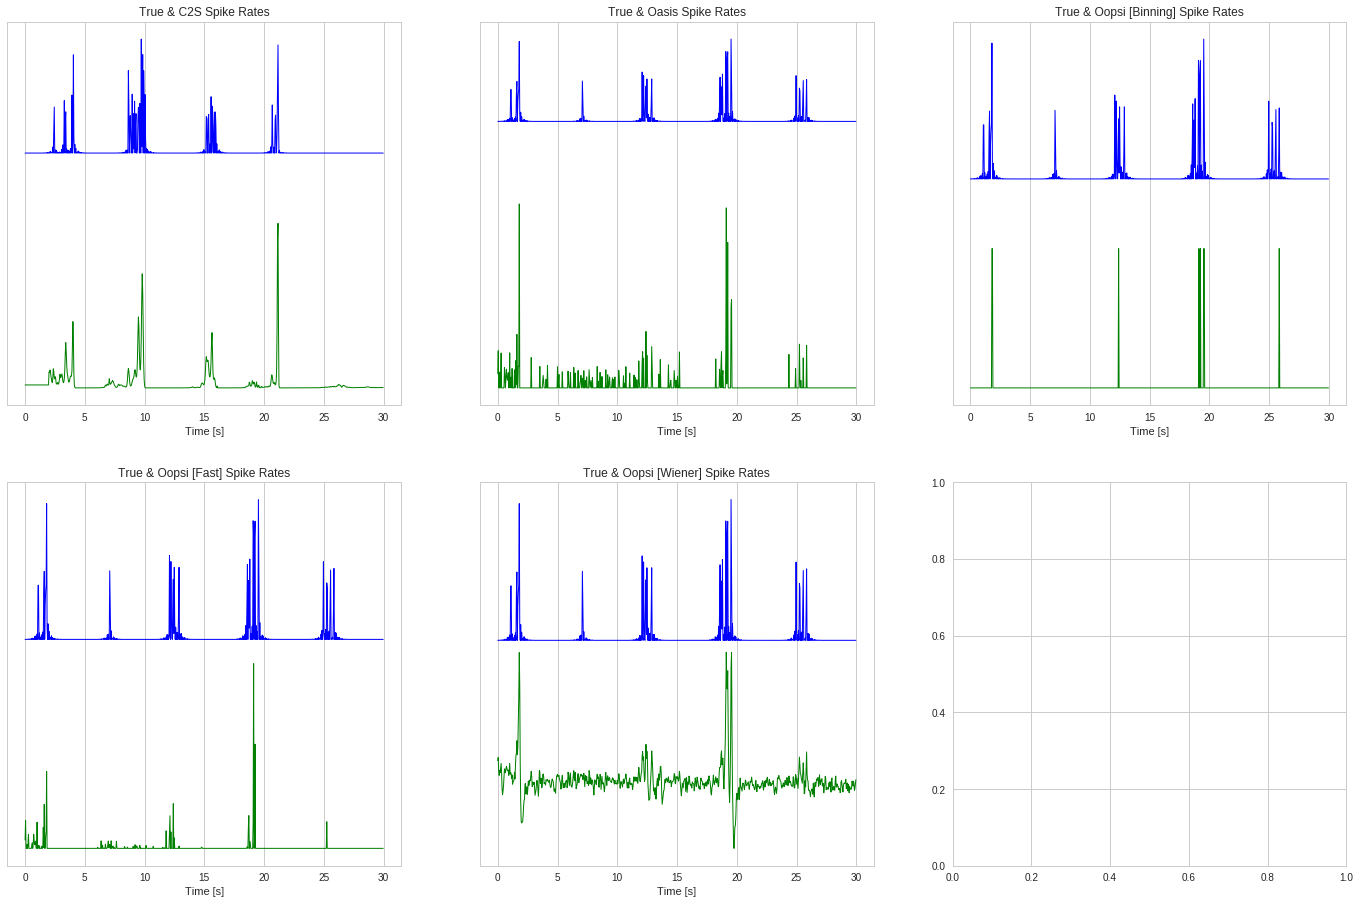

In [71]:
# fill in plot here
plt.figure(figsize=(24, 24))

dt = 1/25
segment_size = 30
t = np.arange(0, segment_size, dt)

c2sPlot = plt.subplot(3, 3, 1)
c2sPlot.axes.get_yaxis().set_visible(False)
plt.title("True & C2S Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[0:(int)(segment_size/dt)]+1, 'blue', linewidth=1)
plt.plot(t, sp_hat_c2s[0:(int)(segment_size/dt)]*0.6, 'green', linewidth=1)


oasisPlot = plt.subplot(3, 3, 2)
oasisPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oasis Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+1.3, 'blue', linewidth=1)
plt.plot(t, sp_hat_oasis[5000:5000+(int)(segment_size/dt)]*0.4, 'green', linewidth=1)

oopsiBinningPlot = plt.subplot(3, 3, 3)
oopsiBinningPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oopsi [Binning] Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+0.6, 'blue', linewidth=1)
plt.plot(t, sp_hat_oopsi_binning[5000:5000+(int)(segment_size/dt)]*0.4, 'green', linewidth=1)

oopsiFastPlot = plt.subplot(3, 3, 4)
oopsiFastPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oopsi [Fast] Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+0.6, 'blue', linewidth=1)
plt.plot(t, sp_hat_oopsi_fast[5000:5000+(int)(segment_size/dt)]*1.2, 'green', linewidth=1)

oopsiWienerPlot = plt.subplot(3, 3, 5)
oopsiWienerPlot.axes.get_yaxis().set_visible(False)
plt.title("True & Oopsi [Wiener] Spike Rates")
plt.xlabel("Time [s]")
plt.plot(t, sp[5000:5000+(int)(segment_size/dt)]+0.4, 'blue', linewidth=1)
plt.plot(t, sp_hat_oopsi_wiener[5000:5000+(int)(segment_size/dt)]*1.2, 'green', linewidth=1)

lastPlot = plt.subplot(3, 3, 6)
# plt.text(0.5, 0.5, "😂", fontproperties=prop)

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation coefficient between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [18]:
tau = .5 
spShape = (np.shape(signal.decimate(ogb_spikes.iloc[:, 0], 4))[0], np.shape(ogb_spikes)[1])
all_sp_gt = np.zeros(spShape)
all_sp_hat_deconv = np.zeros(spShape)
all_sp_hat_c2s = np.zeros(spShape)
all_sp_hat_oasis = np.zeros(spShape)
all_sp_hat_oopsi_binning = np.zeros(spShape)
all_sp_hat_oopsi_fast = np.zeros(spShape)
all_sp_hat_oopsi_wiener = np.zeros(spShape)

for idx in range(0, np.shape(ogb_calcium)[1]): 
    ogb_calcium.iloc[:,idx] = np.nan_to_num(ogb_calcium.iloc[:,idx])
    ogb_spikes.iloc[:,idx] = np.nan_to_num(ogb_spikes.iloc[:,idx])
    
    ca = signal.decimate(ogb_calcium.iloc[:,idx], 4) 
    sp = signal.decimate(ogb_spikes.iloc[:,idx], 4) 
    sp[sp<0] = 0 # remove decimation artefacts  
    
    padLength = spShape[0]
    _, _, sp_hat_deconv = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="deconvolution")
    sp_hat_c2s = inferSpikesFromCa(ogb_calcium.iloc[:,idx], ogb_spikes.iloc[:,idx], tau, padLength, algorithm="c2s") 
    sp_hat_oasis = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oasis")[1] 
    sp_hat_oopsi_binning = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oopsi-binning")[0]
    sp_hat_oopsi_fast = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oopsi-fast")[0]
    sp_hat_oopsi_wiener = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oopsi-wiener")[0]
    
    all_sp_gt[:, idx] = sp 
    all_sp_hat_deconv[:, idx] = sp_hat_deconv
    all_sp_hat_c2s[:, idx] = sp_hat_c2s
    all_sp_hat_oasis[:, idx] = sp_hat_oasis
    all_sp_hat_oopsi_binning[:, idx] = sp_hat_oopsi_binning
    all_sp_hat_oopsi_fast[:, idx] = sp_hat_oopsi_fast
    all_sp_hat_oopsi_wiener[:, idx] = sp_hat_oopsi_wiener

/opt/conda/lib/python3.6/site-packages/c2s/c2s.py:509: UserWarning: The default model expects calcium traces sampled at 100 Hz.
  warn('The default model expects calcium traces sampled at 100 Hz.')
/opt/conda/lib/python3.6/site-packages/oasis/functions.py:815: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[1:])[0]


Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...


In [19]:
all_correlation_deconv = np.zeros(spShape[1])
all_correlation_c2s = np.zeros(spShape[1])
all_correlation_oasis = np.zeros(spShape[1])
all_correlation_oopsi_binning = np.zeros(spShape[1])
all_correlation_oopsi_fast = np.zeros(spShape[1])
all_correlation_oopsi_wiener = np.zeros(spShape[1])
for idx in range(0, spShape[1]): 
    all_correlation_deconv[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_deconv[:, idx])[0, 1]
    all_correlation_c2s[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_c2s[:, idx])[0, 1]
    all_correlation_oasis[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oasis[:, idx])[0, 1]
    all_correlation_oopsi_binning[idx] =  np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oopsi_binning[:, idx])[0, 1]
    all_correlation_oopsi_fast[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oopsi_fast[:, idx])[0, 1]
    all_correlation_oopsi_wiener[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oopsi_wiener[:, idx])[0, 1]

Create OGB dataframe

In [20]:
ogb_df = pd.DataFrame(columns=['Cell', 'Deconvolution', 'C2S', 'Oasis', 'Oopsi-Binning', 'Oopsi-Fast', 'Oopsi-Wiener', 'Indicator'], 
                      index=np.arange(0, spShape[1]))

for idx in range(0, spShape[1], 1): 
    cell = idx
    ogb_df.loc[idx, ['Cell', 'Deconvolution', 'C2S', 'Oasis', 'Oopsi-Binning', 'Oopsi-Fast', 'Oopsi-Wiener', 'Indicator']] = [cell+1, all_correlation_deconv[cell], all_correlation_c2s[cell], all_correlation_oasis[cell], all_correlation_oopsi_binning[cell], all_correlation_oopsi_fast[cell], all_correlation_oopsi_wiener[cell], 'OGB']

In [21]:
ogb_df

,Cell,Deconvolution,C2S,Oasis,Oopsi-Binning,Oopsi-Fast,Oopsi-Wiener,Indicator
0,1,0.385868,0.448055,0.491709,0.208256,0.492211,0.449527,OGB
1,2,0.148963,0.372387,0.201118,0.105777,0.265568,0.372257,OGB
2,3,0.181562,0.477047,0.337246,0.137264,0.413485,0.294952,OGB
3,4,0.263911,0.445576,0.359516,0.0983013,0.426854,0.419275,OGB
4,5,0.293244,0.555265,0.444129,0.054632,0.480837,0.472988,OGB
5,6,0.27221,0.434017,0.414216,0.0470214,0.447535,0.471284,OGB
6,7,0.277082,0.443142,0.444153,0.0914859,0.436573,0.485917,OGB
7,8,0.296152,0.595899,0.430996,-0.00185611,0.466233,0.530703,OGB
8,9,0.163073,0.485541,0.238692,0.106932,0.366876,0.377831,OGB
9,10,0.310771,0.421486,0.383161,0.212556,0.374408,0.408527,OGB


Evaluate on GCamp data

In [22]:
tau = .1
spShape = (np.shape(signal.decimate(gcamp_spikes.iloc[:, 0], 4))[0], np.shape(gcamp_spikes)[1])
all_sp_gt = np.zeros(spShape)
all_sp_hat_deconv = np.zeros(spShape)
all_sp_hat_c2s = np.zeros(spShape)
all_sp_hat_oasis = np.zeros(spShape)
all_sp_hat_oopsi_binning = np.zeros(spShape)
all_sp_hat_oopsi_fast = np.zeros(spShape)
all_sp_hat_oopsi_wiener = np.zeros(spShape)

for idx in range(0, np.shape(gcamp_calcium)[1]): 
    gcamp_calcium.iloc[:,idx] = np.nan_to_num(gcamp_calcium.iloc[:,idx])
    gcamp_spikes.iloc[:,idx] = np.nan_to_num(gcamp_spikes.iloc[:,idx])
    
    ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4) 
    sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4) 
    sp[sp<0] = 0 # remove decimation artefacts  
    
    padLength = spShape[0]
    _, _, sp_hat_deconv = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="deconvolution")
    sp_hat_c2s = inferSpikesFromCa(gcamp_calcium.iloc[:,idx], gcamp_spikes.iloc[:,idx], tau, padLength, algorithm="c2s") 
    sp_hat_oasis = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oasis")[1] 
    sp_hat_oopsi_binning = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oopsi-binning")[0]
    sp_hat_oopsi_fast = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oopsi-fast")[0]
    sp_hat_oopsi_wiener = inferSpikesFromCa(ca, sp, tau, padLength, algorithm="oopsi-wiener")[0]
    
    all_sp_gt[:, idx] = sp 
    all_sp_hat_deconv[:, idx] = sp_hat_deconv
    all_sp_hat_c2s[:, idx] = sp_hat_c2s
    all_sp_hat_oasis[:, idx] = sp_hat_oasis
    all_sp_hat_oopsi_binning[:, idx] = sp_hat_oopsi_binning
    all_sp_hat_oopsi_fast[:, idx] = sp_hat_oopsi_fast
    all_sp_hat_oopsi_wiener[:, idx] = sp_hat_oopsi_wiener

/opt/conda/lib/python3.6/site-packages/c2s/c2s.py:509: UserWarning: The default model expects calcium traces sampled at 100 Hz.
  warn('The default model expects calcium traces sampled at 100 Hz.')
/opt/conda/lib/python3.6/site-packages/oasis/functions.py:815: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[1:])[0]


Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...
Predicting cell 0...


Create GCamp dataframe

In [23]:
all_correlation_deconv = np.zeros(spShape[1])
all_correlation_c2s = np.zeros(spShape[1])
all_correlation_oasis = np.zeros(spShape[1])
all_correlation_oopsi_binning = np.zeros(spShape[1])
all_correlation_oopsi_fast = np.zeros(spShape[1])
all_correlation_oopsi_wiener = np.zeros(spShape[1])
for idx in range(0, spShape[1]): 
    all_correlation_deconv[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_deconv[:, idx])[0, 1]
    all_correlation_c2s[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_c2s[:, idx])[0, 1]
    all_correlation_oasis[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oasis[:, idx])[0, 1]
    all_correlation_oopsi_binning[idx] =  np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oopsi_binning[:, idx])[0, 1]
    all_correlation_oopsi_fast[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oopsi_fast[:, idx])[0, 1]
    all_correlation_oopsi_wiener[idx] = np.corrcoef(all_sp_gt[:, idx], all_sp_hat_oopsi_wiener[:, idx])[0, 1]

In [24]:
gcamp_df = pd.DataFrame(columns=['Cell', 'Deconvolution', 'C2S', 'Oasis', 'Oopsi-Binning', 'Oopsi-Fast', 'Oopsi-Wiener', 'Indicator'], 
                      index=np.arange(0, spShape[1]))

for idx in range(0, spShape[1], 1): 
    cell = idx
    gcamp_df.loc[idx, ['Cell', 'Deconvolution', 'C2S', 'Oasis', 'Oopsi-Binning', 'Oopsi-Fast', 'Oopsi-Wiener', 'Indicator']] = [cell+1, all_correlation_deconv[cell], all_correlation_c2s[cell], all_correlation_oasis[cell], all_correlation_oopsi_binning[cell], all_correlation_oopsi_fast[cell], all_correlation_oopsi_wiener[cell], 'GCAMP']

In [25]:
gcamp_df

,Cell,Deconvolution,C2S,Oasis,Oopsi-Binning,Oopsi-Fast,Oopsi-Wiener,Indicator
0,1,0.548347,0.363818,0.614908,0.578243,0.567413,0.665609,GCAMP
1,2,0.535508,0.535738,0.664027,0.559081,0.641495,0.618535,GCAMP
2,3,0.524531,0.33008,0.577736,0.648631,0.493692,0.609629,GCAMP
3,4,0.502514,0.302604,0.553215,0.435753,0.552237,0.605278,GCAMP
4,5,0.429517,0.328266,0.525481,0.472169,0.660513,0.476323,GCAMP
5,6,0.472946,0.490398,0.551527,0.515428,0.494482,0.554398,GCAMP
6,7,0.461321,0.382303,0.555731,0.564324,0.458662,0.576657,GCAMP
7,8,0.44728,0.400306,0.592456,0.487275,0.560626,0.554548,GCAMP
8,9,0.386292,0.551743,0.625795,0.502622,0.595656,0.53456,GCAMP
9,10,0.464352,0.424742,0.603127,0.582473,0.579982,0.566374,GCAMP


Combine both dataframes and plot

In [26]:
merged = pd.concat([ogb_df, gcamp_df])

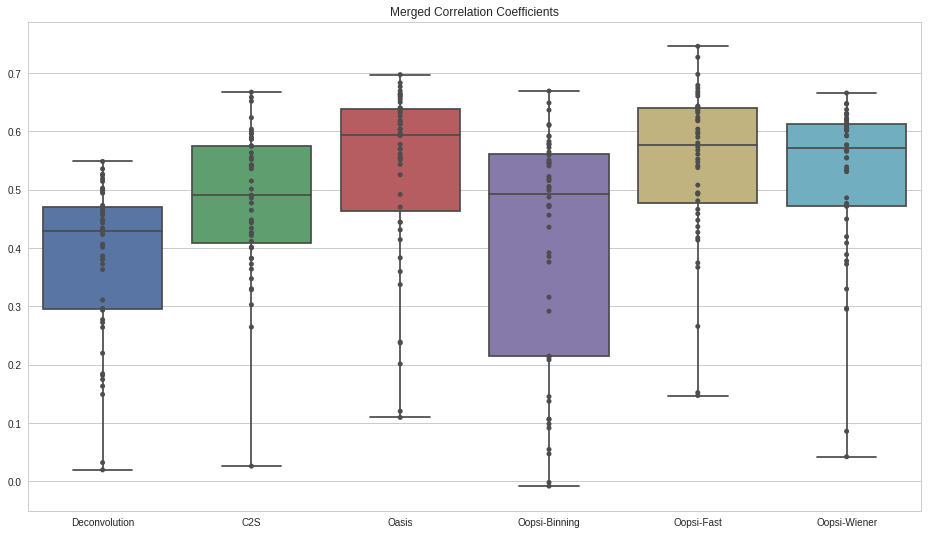

In [27]:
plt.figure(figsize=(16, 9))
plt.title("Merged Correlation Coefficients")

sns.boxplot(data = merged.iloc[:, 1:], whis=np.inf)
sns.stripplot(data = merged.iloc[:, 1:],color='.3')

In [28]:
combined_df = pd.concat([ogb_df.rename(index=str, columns={"Deconvolution":"OGB_Deconvolution", "C2S":"OGB_C2S", "Oasis":"OGB_Oasis", "Oopsi-Binning":"OGB_Oopsi-Binning", "Oopsi-Fast":"OGB_Oopsi-Fast", "Oopsi-Wiener":"OGB_Oopsi-Wiener"}), gcamp_df.rename(index=str, columns={"Deconvolution":"GCAMP_Deconvolution", "C2S":"GCAMP_C2S", "Oasis":"GCAMP_Oasis", "Oopsi-Binning":"GCAMP_Oopsi-Binning", "Oopsi-Fast":"GCAMP_Oopsi-Fast", "Oopsi-Wiener":"GCAMP_Oopsi-Wiener"})])

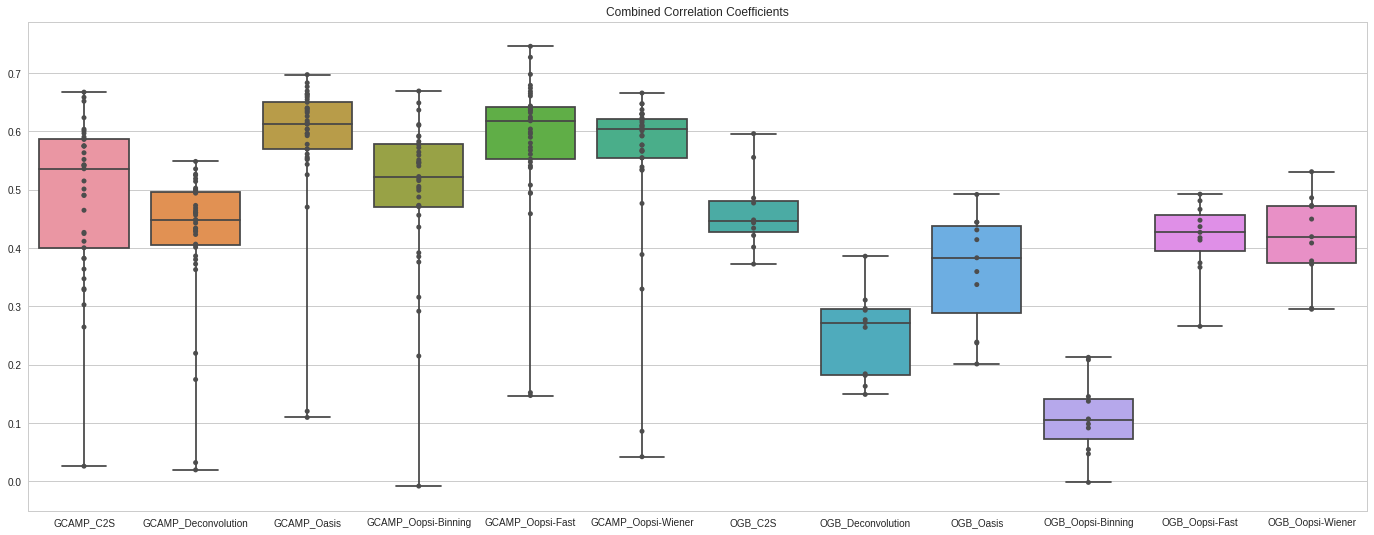

In [30]:
plt.figure(figsize=(24, 9))
plt.title("Combined Correlation Coefficients")

sns.boxplot(data = combined_df.iloc[:, 1:], whis=np.inf)
sns.stripplot(data = combined_df.iloc[:, 1:],color='.3')